In [75]:
from PIL import Image, ImageOps
from IPython.display import Image as DPImage
import os
import numpy as np
from random import sample
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn as sk
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import random
import csv
import skimage

from sklearn.model_selection import train_test_split

from tensorflow.keras.datasets import cifar100
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import Input

seed = 2023
np.random.seed(seed)  

In [76]:
def display_img(image, title=''):
    plt.title(title)
    plt.imshow(tf.keras.utils.array_to_img(image))
    plt.axis('off')
    plt.show()

## 0) Load images
load all images in a lists.

In [77]:
def readImages(data_dir):
    image_ids = os.listdir(data_dir)
    images = []
    for i in range(len(image_ids)):

        path_images = f"{data_dir}/{image_ids[i]}/images"
        filename_image = os.listdir(path_images)[0]
        image = tf.keras.utils.load_img(f"{path_images}/{filename_image}")
        images.append(image)
    
    return images, image_ids

In [78]:
images_train, imageIDs_train = readImages("./data/stage1_train")
images_val, imageIDs_val = readImages("./data/stage1_test")
images_test, imageIDs_test = readImages("./data/stage2_test_final")

## 1) Gray scaling
Change all images to gray scale.

In [79]:
def grayscaleImages(images0):
    images = []
    for image in images0:
        image = tf.image.rgb_to_grayscale(image)
        images.append(image)
    
    return images

In [80]:
images_train = grayscaleImages(images_train)
images_val = grayscaleImages(images_val)
images_test = grayscaleImages(images_test)

The image id is 0121d6759c5adb290c8e828fc882f37dfaf3663ec885c663859948c154a443ed, the dimension of the image is (320, 256) (width x height).
The original image


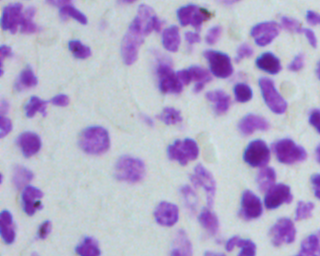

The image after grayscaling


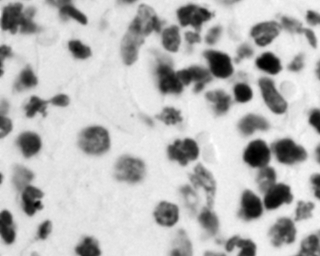

The original mask


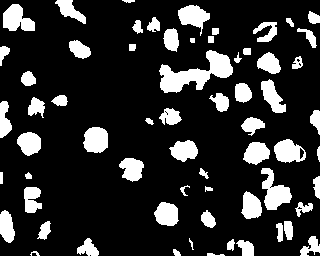

In [81]:
idx = 3
img_size = Image.open(f"./data/stage1_train/{imageIDs_train[idx]}/images/{imageIDs_train[idx]}.png").size
print(f"The image id is {imageIDs_train[idx]}, the dimension of the image is {img_size} (width x height).")
print('The original image')
display(DPImage(f"./data/stage1_train/{imageIDs_train[idx]}/images/{imageIDs_train[idx]}.png"))

print('The image after grayscaling')
display(tf.keras.utils.array_to_img(images_train[idx]))

print('The original mask')
display(DPImage(f"./data/stage1_train/{imageIDs_train[idx]}/combined_masks/{imageIDs_train[idx]}.png"))

## 2) Inverting background
Change all background to black.

In [82]:
def invertImages(images0, threshold = 0.6):
    images = []
    for image in images0:
        if np.sum(image[:,:,0]/255) > threshold*image.shape[0]*image.shape[1]:  
            image = 255 - image
        images.append(image)
    
    return images

In [83]:
images_train = invertImages(images_train)
images_val = invertImages(images_val)
images_test = invertImages(images_test)

The image id is 0121d6759c5adb290c8e828fc882f37dfaf3663ec885c663859948c154a443ed, the dimension of the image is (320, 256) (width x height).
The original image


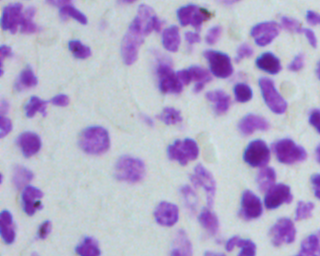

The image after grayscaling and inverting


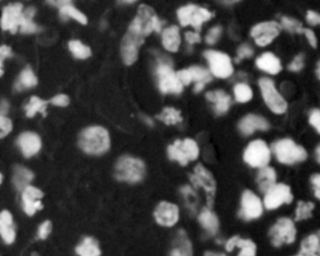

The original mask


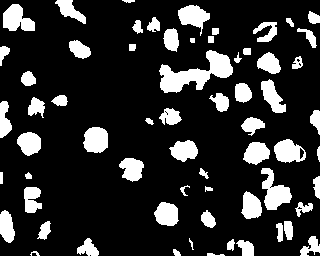

In [84]:
idx = 3
img_size = Image.open(f"./data/stage1_train/{imageIDs_train[idx]}/images/{imageIDs_train[idx]}.png").size
print(f"The image id is {imageIDs_train[idx]}, the dimension of the image is {img_size} (width x height).")
print('The original image')
display(DPImage(f"./data/stage1_train/{imageIDs_train[idx]}/images/{imageIDs_train[idx]}.png"))

print('The image after grayscaling and inverting')
display(tf.keras.utils.array_to_img(images_train[idx]))

print('The original mask')
display(DPImage(f"./data/stage1_train/{imageIDs_train[idx]}/combined_masks/{imageIDs_train[idx]}.png"))

## 3) Contrast ratio
it is probably not necessary to adjust brighness after gray scaling and inverting. However, it is pretty interesting to adjust the contrast ratio.

In [85]:
def contrastImages(images0, ratio = 2):
    images = []
    for image in images0:
        image = tf.image.adjust_contrast(image, ratio)
        images.append(image)
        
    
    return images

In [86]:
images_train = contrastImages(images_train)
images_val = contrastImages(images_val)
images_test = contrastImages(images_test)

The image id is 0121d6759c5adb290c8e828fc882f37dfaf3663ec885c663859948c154a443ed, the dimension of the image is (320, 256) (width x height).
The original image


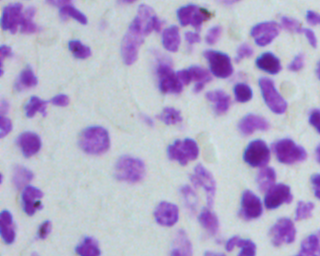

The image after grayscaling, inverting and adjusting contrast ratio


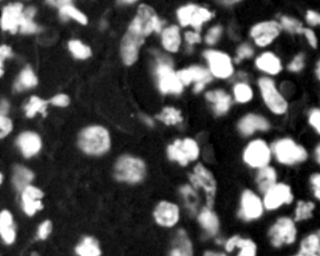

The original mask


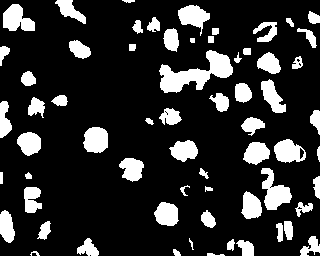

In [87]:
idx = 3
img_size = Image.open(f"./data/stage1_train/{imageIDs_train[idx]}/images/{imageIDs_train[idx]}.png").size
print(f"The image id is {imageIDs_train[idx]}, the dimension of the image is {img_size} (width x height).")
print('The original image')
display(DPImage(f"./data/stage1_train/{imageIDs_train[idx]}/images/{imageIDs_train[idx]}.png"))

print('The image after grayscaling, inverting and adjusting contrast ratio')
display(tf.keras.utils.array_to_img(images_train[idx]))

print('The original mask')
display(DPImage(f"./data/stage1_train/{imageIDs_train[idx]}/combined_masks/{imageIDs_train[idx]}.png"))

## 3) Save images

In [88]:
def saveImages(images0, data_dir):
    image_ids = os.listdir(data_dir)
    for i, image in enumerate(images0):
        p = f"{data_dir}/{image_ids[i]}/adjusted"
        if not os.path.exists(p):
            os.mkdir(p)
        keras.preprocessing.image.save_img(f"{p}/{image_ids[i]}.png", image)
        
    return None

In [89]:
saveImages(images_train, "./data/stage1_train")
saveImages(images_val, "./data/stage1_test")
saveImages(images_test, "./data/stage2_test_final")

## 1) Resizing
The process is one of the options that is resizing images to a fixed size (128, 128).

In [90]:
def readAndResizeImages(data_dir, height = 128, width = 128, with_labels=True):
    
    image_ids = os.listdir(data_dir)
    X = np.zeros((len(image_ids), height, width, 3), dtype=np.uint8)
    Y = np.zeros((len(image_ids), height, width, 1), dtype=np.bool_)
    for i in range(len(image_ids)):
        sample = {}

        path_images = f"{data_dir}/{image_ids[i]}/adjusted"
        filename_image = os.listdir(path_images)[0]
        image = tf.keras.utils.load_img(f"{path_images}/{filename_image}")
        image = tf.image.resize(image, [height, width])
        X[i] = image
        
        if with_labels:
            path_mask = f"{data_dir}/{image_ids[i]}/combined_masks"
            filename_mask = os.listdir(path_mask)[0]
            mask = tf.keras.utils.load_img(f"{path_mask}/{filename_mask}")
            mask = tf.image.resize(mask, [height, width], method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)[:,:,:1]
            Y[i] = mask
    
    return X, Y, image_ids

In [91]:
X_train, Y_train, imageIDs_train = readAndResizeImages("./data/stage1_train")
X_val, Y_val, imageIDs_val = readAndResizeImages("./data/stage1_test")
X_test, _, imageIDs_test = readAndResizeImages("./data/stage2_test_final", with_labels=False)

The image id is 0121d6759c5adb290c8e828fc882f37dfaf3663ec885c663859948c154a443ed, the dimension of the image is (320, 256) (width x height).
The image with previous pre_processing


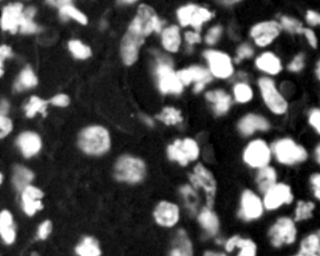

The original mask


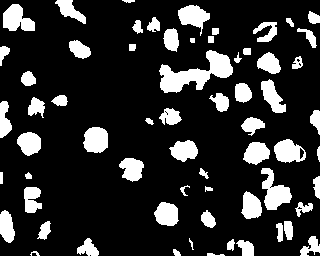

The image after resizing


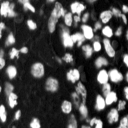

The mask after resizing


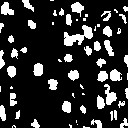

In [92]:
idx = 3
img_size = Image.open(f"./data/stage1_train/{imageIDs_train[idx]}/images/{imageIDs_train[idx]}.png").size
print(f"The image id is {imageIDs_train[idx]}, the dimension of the image is {img_size} (width x height).")
print('The image with previous pre_processing')
display(DPImage(f"./data/stage1_train/{imageIDs_train[idx]}/adjusted/{imageIDs_train[idx]}.png"))

print('The original mask')
display(DPImage(f"./data/stage1_train/{imageIDs_train[idx]}/combined_masks/{imageIDs_train[idx]}.png"))
print('The image after resizing')
display(tf.keras.utils.array_to_img(X_train[idx]))
print('The mask after resizing')
display(tf.keras.utils.array_to_img(Y_train[idx]))

## 2) Resizing with padding
The process is one of the options that is padding images to a fixed size (256, 256). Resizes an image to a target width and height by keeping the aspect ratio the same without distortion. If the target dimensions don't match the image dimensions, the image is resized and then padded with zeroes to match requested dimensions.

In [102]:
def readAndresizepadImages(data_dir, height = 128, width = 128, with_labels=True):
    
    image_ids = os.listdir(data_dir)
    X = np.zeros((len(image_ids), height, width, 3), dtype=np.uint8)
    Y = np.zeros((len(image_ids), height, width, 1), dtype=np.bool_)
    for i in range(len(image_ids)):
        sample = {}

        path_images = f"{data_dir}/{image_ids[i]}/adjusted"
        filename_image = os.listdir(path_images)[0]
        image = tf.keras.utils.load_img(f"{path_images}/{filename_image}")
        image = tf.image.resize_with_pad(image, height, width)
        X[i] = image
        
        if with_labels:
            path_mask = f"{data_dir}/{image_ids[i]}/combined_masks"
            filename_mask = os.listdir(path_mask)[0]
            mask = tf.keras.utils.load_img(f"{path_mask}/{filename_mask}")
            mask = tf.image.resize_with_pad(mask, height, width, method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)[:,:,:1]
            Y[i] = mask
    
    return X, Y, image_ids

In [103]:
X_train, Y_train, imageIDs_train = readAndresizepadImages("./data/stage1_train")
X_val, Y_val, imageIDs_val = readAndresizepadImages("./data/stage1_test")
X_test, _, imageIDs_test = readAndresizepadImages("./data/stage2_test_final", with_labels=False)

The image id is 0121d6759c5adb290c8e828fc882f37dfaf3663ec885c663859948c154a443ed, the dimension of the image is (320, 256) (width x height).
The image with previous pre_processing


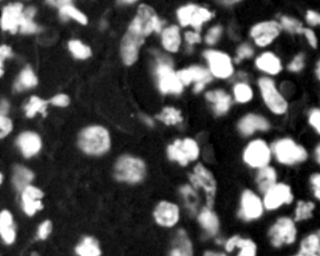

The original mask


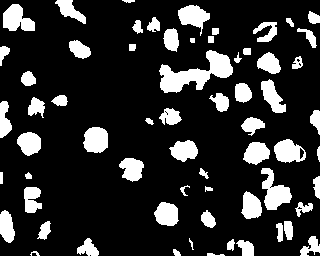

The image after resizing


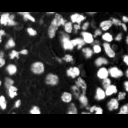

The mask after resizing


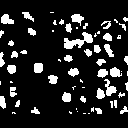

In [104]:
idx = 3
img_size = Image.open(f"./data/stage1_train/{imageIDs_train[idx]}/images/{imageIDs_train[idx]}.png").size
print(f"The image id is {imageIDs_train[idx]}, the dimension of the image is {img_size} (width x height).")
print('The image with previous pre_processing')
display(DPImage(f"./data/stage1_train/{imageIDs_train[idx]}/adjusted/{imageIDs_train[idx]}.png"))

print('The original mask')
display(DPImage(f"./data/stage1_train/{imageIDs_train[idx]}/combined_masks/{imageIDs_train[idx]}.png"))
print('The image after resizing')
display(tf.keras.utils.array_to_img(X_train[idx]))
print('The mask after resizing')
display(tf.keras.utils.array_to_img(Y_train[idx]))

## 3) Ramdom cropping
Randomly crops a tensor to a given size.

In [139]:
def readAndramdomcropImages(data_dir, height = 128, width = 128, ratio = 1.2, with_labels=True):

    image_ids = os.listdir(data_dir)
    n = []
    for i in range(len(image_ids)):
        path_images = f"{data_dir}/{image_ids[i]}/adjusted"
        filename_image = os.listdir(path_images)[0]
        image = tf.keras.utils.load_img(f"{path_images}/{filename_image}")
        image_size = image.size
        n.append(int(np.ceil(image_size[1]/height * image_size[0]/width * ratio)))
    n1 = [sum(n[:i]) for i in range(len(n))]
    n_total = sum(n)

    X = np.zeros((n_total, height, width, 3), dtype=np.uint8)
    Y = np.zeros((n_total, height, width, 1), dtype=np.bool_)

    for i in range(len(image_ids)):
        path_images = f"{data_dir}/{image_ids[i]}/adjusted"
        filename_image = os.listdir(path_images)[0]
        image = tf.keras.utils.load_img(f"{path_images}/{filename_image}")
        image_size = image.size
        h0 = np.random.randint(image_size[1] - height + 1, size=n[i])
        w0 = np.random.randint(image_size[0] - width + 1, size=n[i])

        for j in range(n[i]):
            image1 = tf.image.crop_to_bounding_box(image, h0[j], w0[j], height, width)
            X[n1[i] + j] = image1
        
        if with_labels:
            path_mask = f"{data_dir}/{image_ids[i]}/combined_masks"
            filename_mask = os.listdir(path_mask)[0]
            mask = tf.keras.utils.load_img(f"{path_mask}/{filename_mask}")
            for j in range(n[i]):
                mask1 = tf.image.crop_to_bounding_box(mask, h0[j], w0[j], height, width)[:,:,:1]
                Y[n1[i] + j] = mask1
    
    return X, Y, image_ids, n1

In [140]:
X_train, Y_train, imageIDs_train, n1_train = readAndramdomcropImages("./data/stage1_train")
X_val, Y_val, imageIDs_val, n1_val = readAndramdomcropImages("./data/stage1_test")
X_test, _, imageIDs_test, n1_test = readAndramdomcropImages("./data/stage2_test_final", with_labels=False)

The image id is 0121d6759c5adb290c8e828fc882f37dfaf3663ec885c663859948c154a443ed, the dimension of the image is (320, 256) (width x height).
The original image


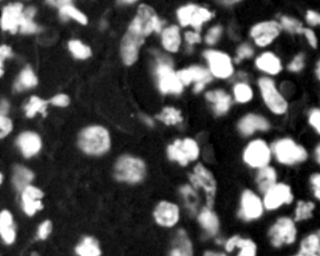

The original mask


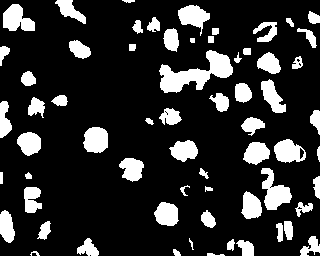

The image after resizing


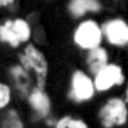

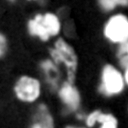

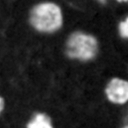

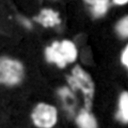

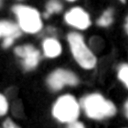

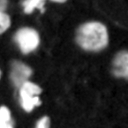

The mask after resizing


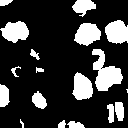

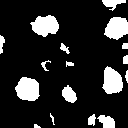

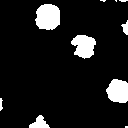

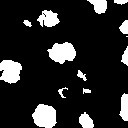

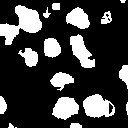

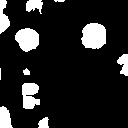

In [145]:
idx = 3
img_size = Image.open(f"./data/stage1_train/{imageIDs_train[idx]}/images/{imageIDs_train[idx]}.png").size
print(f"The image id is {imageIDs_train[idx]}, the dimension of the image is {img_size} (width x height).")
print('The original image')
display(DPImage(f"./data/stage1_train/{imageIDs_train[idx]}/adjusted/{imageIDs_train[idx]}.png"))

print('The original mask')
display(DPImage(f"./data/stage1_train/{imageIDs_train[idx]}/combined_masks/{imageIDs_train[idx]}.png"))
print('The image after resizing')
for idx1 in range(n1_train[idx],n1_train[idx+1]):
    display(tf.keras.utils.array_to_img(X_train[idx1]))
print('The mask after resizing')
for idx1 in range(n1_train[idx],n1_train[idx+1]):
    display(tf.keras.utils.array_to_img(Y_train[idx1]))

## 4) Padding
Pad image with zeros to the specified height and width.

In [99]:
def readAndpadImages(data_dir, height = 1040, width = 1388, with_labels=True):
    
    image_ids = os.listdir(data_dir)
    X = np.zeros((len(image_ids), height, width, 3), dtype=np.uint8)
    Y = np.zeros((len(image_ids), height, width, 1), dtype=np.bool_)
    for i in range(len(image_ids)):
        sample = {}

        path_images = f"{data_dir}/{image_ids[i]}/adjusted"
        filename_image = os.listdir(path_images)[0]
        image = tf.keras.utils.load_img(f"{path_images}/{filename_image}")
        offset_height = (height - image.size[1])//2
        offset_width = (width - image.size[0])//2
        image = tf.image.pad_to_bounding_box(image, offset_height, offset_width, height, width)
        X[i] = image
        if with_labels:
            path_mask = f"{data_dir}/{image_ids[i]}/combined_masks"
            filename_mask = os.listdir(path_mask)[0]
            mask = tf.keras.utils.load_img(f"{path_mask}/{filename_mask}")
            mask = tf.image.pad_to_bounding_box(mask, offset_height, offset_width, height, width)[:,:,:1]
            Y[i] = mask
    
    return X, Y, image_ids

In [100]:
X_train, Y_train, imageIDs_train = readAndpadImages("./data/stage1_train")
X_val, Y_val, imageIDs_val = readAndpadImages("./data/stage1_test")
X_test, _, imageIDs_test = readAndpadImages("./data/stage2_test_final", with_labels=False)

The image id is 0121d6759c5adb290c8e828fc882f37dfaf3663ec885c663859948c154a443ed, the dimension of the image is (320, 256) (width x height).
The original image


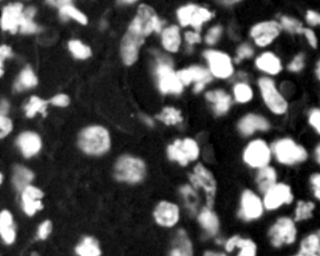

The original mask


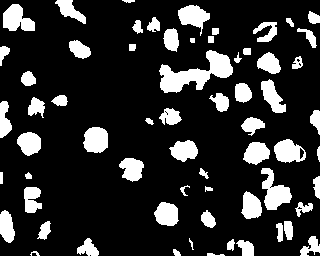

The image after resizing


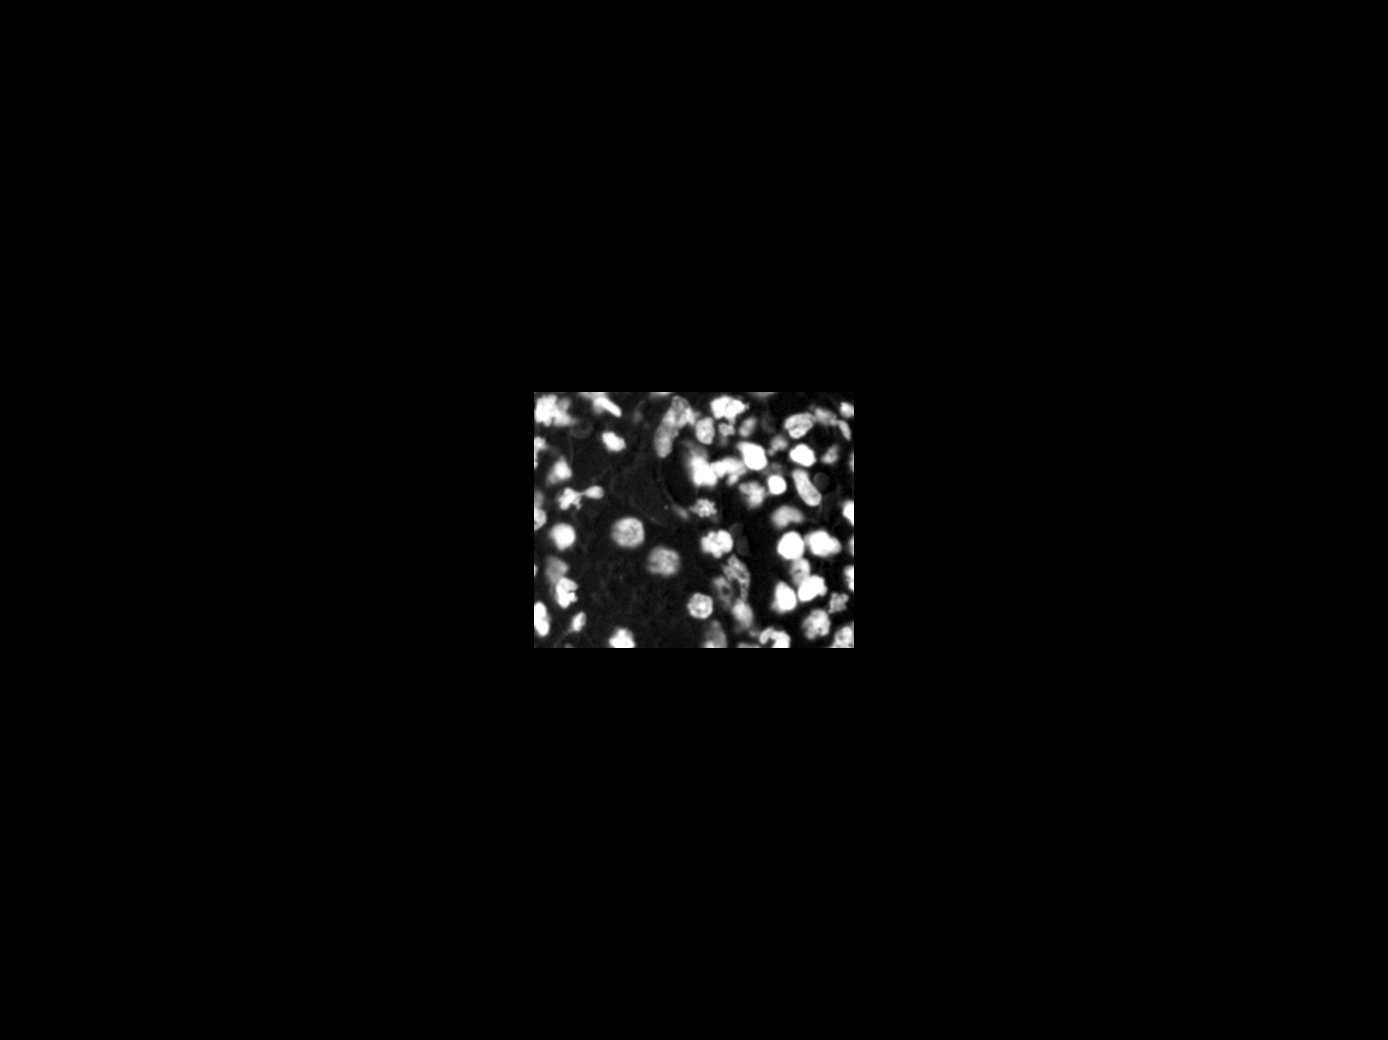

The mask after resizing


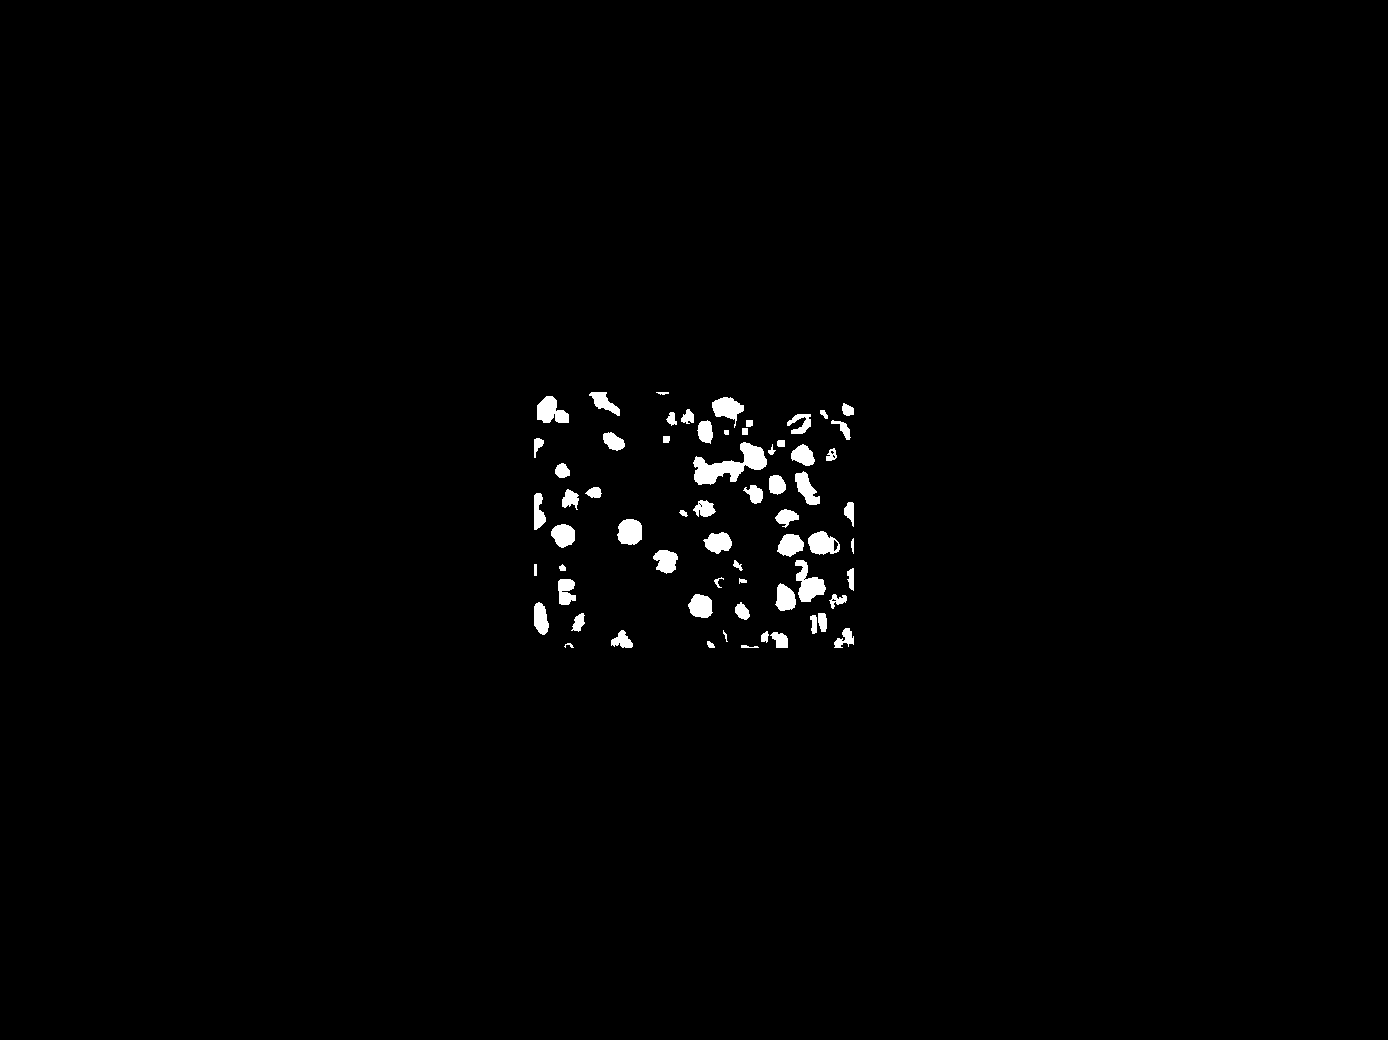

In [101]:
idx = 3
img_size = Image.open(f"./data/stage1_train/{imageIDs_train[idx]}/images/{imageIDs_train[idx]}.png").size
print(f"The image id is {imageIDs_train[idx]}, the dimension of the image is {img_size} (width x height).")
print('The original image')
display(DPImage(f"./data/stage1_train/{imageIDs_train[idx]}/adjusted/{imageIDs_train[idx]}.png"))

print('The original mask')
display(DPImage(f"./data/stage1_train/{imageIDs_train[idx]}/combined_masks/{imageIDs_train[idx]}.png"))
print('The image after resizing')
display(tf.keras.utils.array_to_img(X_train[idx]))
print('The mask after resizing')
display(tf.keras.utils.array_to_img(Y_train[idx]))